# Setup

In [1]:
!source /etc/profile.d/modules.sh
!module load CUDA/11.2
!export PATH=/local/java/cuda-11.2/bin:$PATH
!export LD_LIBRARY_PATH=/local/java/cuda-11.2/lib64:/local/java/cudnn-8.1_for_cuda_11.2/lib64:$LD_LIBRARY_PATH  # this line is needed for it to recognise gpu devices -- run this in the terminal
!export CUDA_HOME=/local/java/cuda-11.2
import os 
import tensorflow as tf
import numpy as np
import random
import cv2
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
from datetime import datetime
from keras import backend as K
from read_data_train import read_data_train
from read_data_val import read_data_val
from read_data_test import read_data_test

print(tf.__version__)  # 2.10.0
print(tf.config.list_physical_devices('GPU'))  # should show gpu available


2025-02-20 16:48:29.304048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 16:48:29.386276: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 16:48:29.406761: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 16:48:30.995172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-02-20 16:48:35.727766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-20 16:48:35.736875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-20 16:48:35.736987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Preprocess the images

In [2]:
def preprocess(image_path):
    # read the file 
    raw = tf.io.read_file(image_path)
    img = tf.io.decode_image(raw, expand_animations=False, channels = 3)
    img = tf.image.resize(img, size = (256,256), preserve_aspect_ratio=True)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    img = tf.cast(img, tf.float32)/255.0       # convert rgb values to between 0 and 1
    return img 

def preprocess_pair(pair):
    imgA = preprocess(pair[0])
    imgB = preprocess(pair[1])
    return (imgA, imgB)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation((-0.4, 0.4)),
    tf.keras.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0., 1.)),
    tf.keras.layers.GaussianNoise(0.005),
    tf.keras.layers.RandomContrast(factor=(0.1, 0.9)),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

2025-02-20 16:48:35.746946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 16:48:35.747694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-20 16:48:35.747843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-20 16:48:35.747903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

# Hyper parameters

In [3]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATION = 2
MARGIN = 1
DO_DATA_AUGMENTATION = True
UNFREEZE_LIMIT = 0.3
DENSE_LAYER_WIDTH = 256
LEARNING_RATE = 0.001

# Method to display processed pairs

In [4]:
def show_preprocessed_image(imgA, imgB, label):
    # augment the images here 
    if (DO_DATA_AUGMENTATION):
        imgA = data_augmentation(imgA, training = True)
        imgB = data_augmentation(imgB, training = True)
    
    imgA, imgB = imgA.numpy(), imgB.numpy()
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle("Label: " + str(label))
    axes[0].imshow(imgA)
    axes[1].imshow(imgB)
    plt.show()

# Build the training and validation dataset

In [5]:
training_pairs, training_pairs_labels = read_data_train()
validation_pairs, validation_pairs_labels = read_data_val()

Number of train pairs: 80110
Number of train positives: 26264
Number of train negatives: 53846
Number of validation pairs: 14938
Number of validation positives: 7381
Number of validation negatives: 7557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4888363].


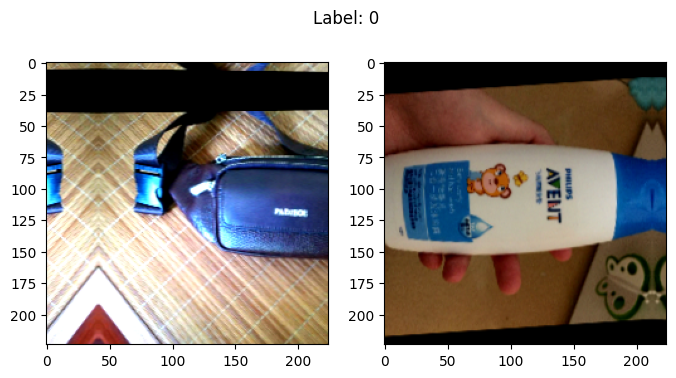

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11817865..1.0274007].


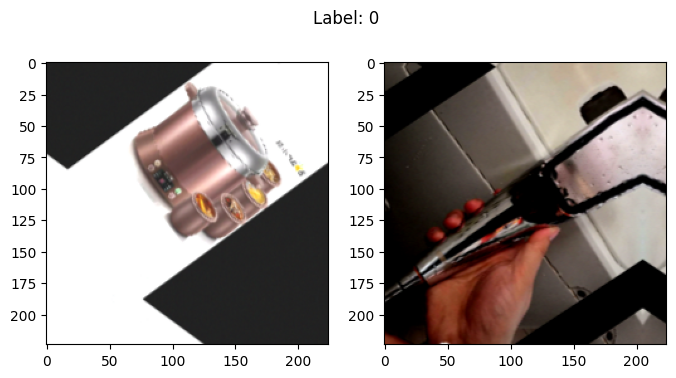

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05949224..1.1975783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3099996].


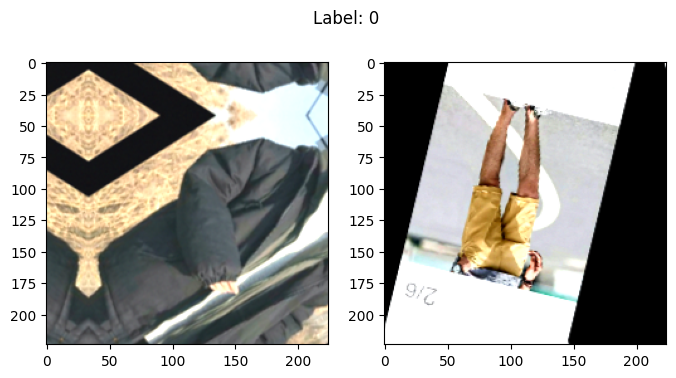

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05010421..1.1240394].


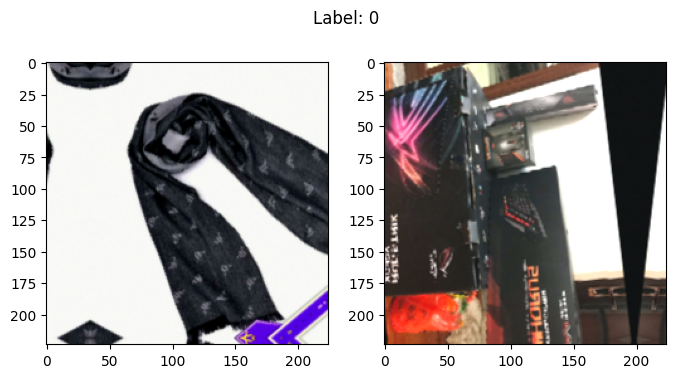

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00047330253..1.2019376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1499527].


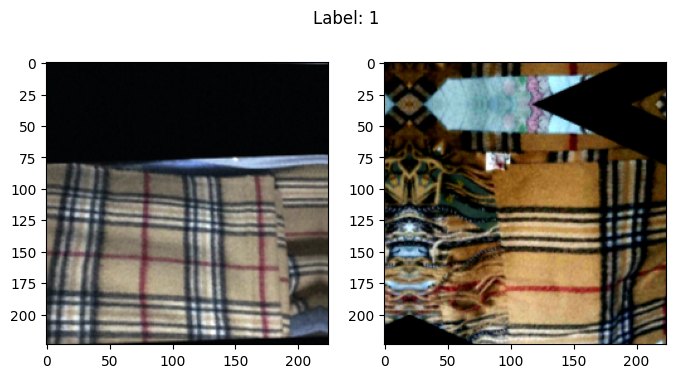

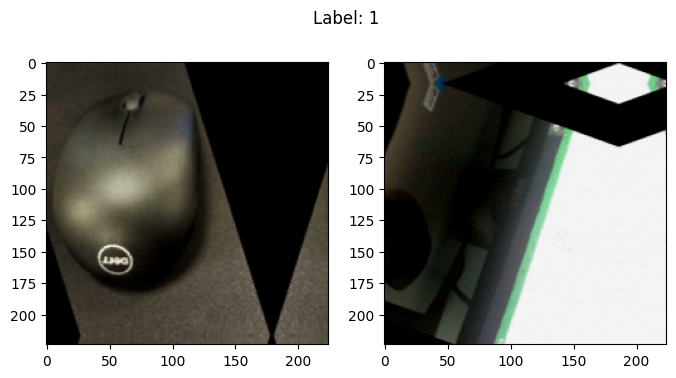

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0150226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08378499..1.2840805].


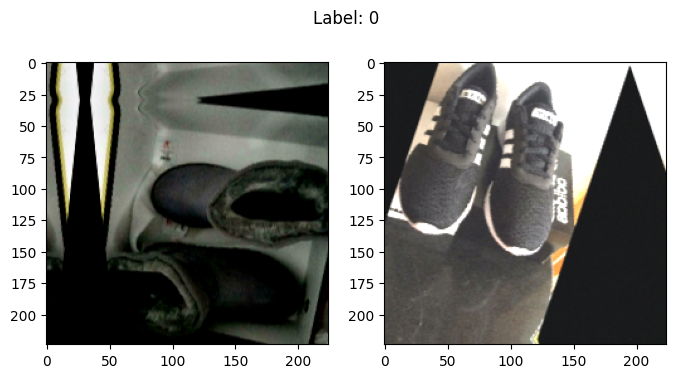

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1881863].


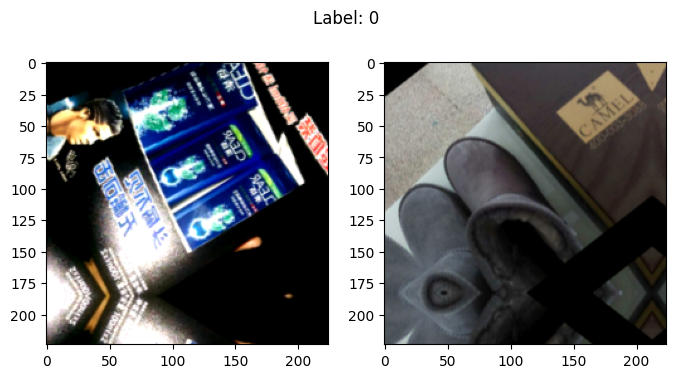

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5160415].


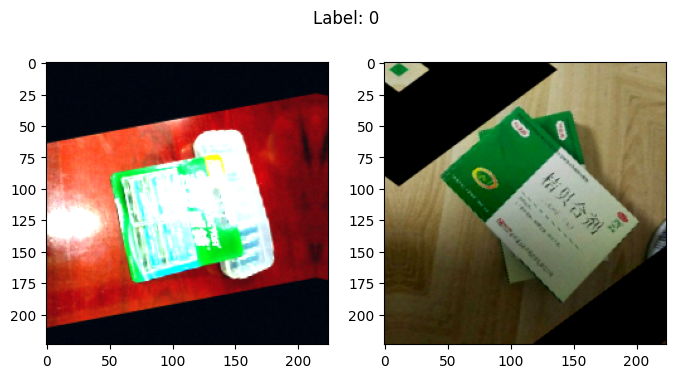

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3958153].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1249926].


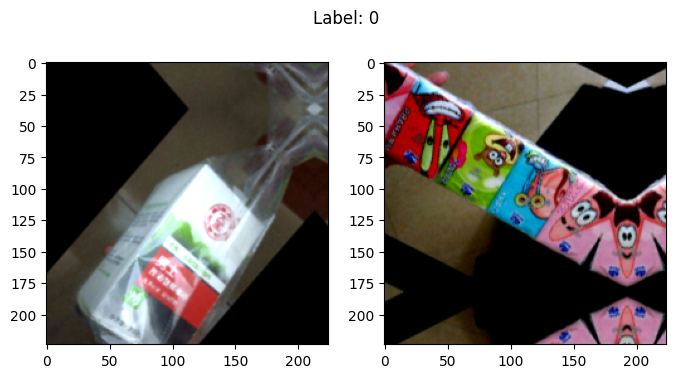

In [6]:
# display the first 10 pairs 
for i in range(10):
    ia, ib = training_pairs[i]
    label = int(training_pairs_labels[i])
    pa, pb = preprocess(ia), preprocess(ib)
    show_preprocessed_image(pa, pb, label)


In [7]:
def build_training_dataset():
    pairs_tensor = tf.convert_to_tensor(training_pairs)
    labels_tensor = tf.convert_to_tensor(training_pairs_labels)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (preprocess_pair(pair), label))
    result = result.shuffle(128, reshuffle_each_iteration=True)
    result = result.repeat()
    result = result.batch(BATCH_SIZE_TRAIN)
    if (DO_DATA_AUGMENTATION):
        result = result.map(lambda pair, y: ((data_augmentation(pair[0], training=True),data_augmentation(pair[1], training=True)), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    result = result.prefetch(tf.data.AUTOTUNE)

    return result

train_dataset = build_training_dataset()

def build_validation_dataset():

    pairs_tensor = tf.convert_to_tensor(validation_pairs)
    labels_tensor = tf.convert_to_tensor(validation_pairs_labels)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (preprocess_pair(pair), label))
    result = result.batch(BATCH_SIZE_VALIDATION)
    result = result.prefetch(tf.data.AUTOTUNE)

    return result

validation_dataset = build_validation_dataset()

# Calculate euclidean distance

In [8]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_squared = K.sum(K.square(x-y), axis = 1, keepdims= True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Make embedding
embedding is each sub, identical model

In [9]:
def make_embedding():
    inputs = tf.keras.layers.Input(INPUT_SHAPE)
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    
    base_model.trainable = True
    limit = len(base_model.layers)-int(len(base_model.layers)*UNFREEZE_LIMIT)
    for layer in base_model.layers[:limit]:
        layer.trainable =  False
          
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # add dropout layer 
    x = tf.keras.layers.Dropout(0.1)(x)
    
    outputs=tf.keras.layers.Dense(DENSE_LAYER_WIDTH)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model
    

# Build siamese model

In [10]:
def make_siamese_model():
    # create embedding
    embedding = make_embedding()

    # create the same embedding for the two inputs 
    input_a = Input(shape = INPUT_SHAPE, name = "first_image")
    input_b = Input(shape = INPUT_SHAPE, name = "second_image")

    embedding_a = embedding(input_a)
    embedding_b = embedding(input_b)

    # Create the final euclidean distance layer
    output = Lambda(euclidean_distance, name = "distance")([embedding_a, embedding_b])

    return Model([input_a, input_b], output)

In [11]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 second_image (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 256)          2585920     ['first_image[0][0]',            
                                                                  'second_image[0][0]']     

# Contrastive loss function

In [12]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(MARGIN - y_pred, 0))
    return (y_true * square_pred + (1 - y_true) * margin_square)

# Set up precision and recall

In [13]:
class Custom_Precision(tf.keras.metrics.Precision):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5)   # override the default implementation of >= 0.5 by <0.5 (Distance)
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)
  
class Custom_Recall(tf.keras.metrics.Recall):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)
  
class Custom_Accuracy(tf.keras.metrics.Accuracy):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)

# Set up learning rate decay

In [14]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE,
    decay_steps=100000,     # disabled at the moment. 
    decay_rate=0.96,
    staircase=True
)

# Compile and train model

In [15]:
EPOCHS = 50
model_file = "best_fit.h5"
log_dir = "logs_new"

siamese_model.compile(loss=contrastive_loss, 
                      optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                      metrics=[Custom_Accuracy(), Custom_Precision(), Custom_Recall()]
                      )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights = False)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)      # record the data in tensorboard

history = siamese_model.fit(train_dataset, 
                            steps_per_epoch=math.ceil(len(training_pairs) // (BATCH_SIZE_TRAIN*10)), 
                            validation_data=validation_dataset, 
                            epochs = EPOCHS,
                            callbacks=[early_stop, checkpoint, tensorboard_callback])

Epoch 1/50


2025-02-20 16:48:52.730462: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-02-20 16:48:54.097373: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-20 16:48:54.138792: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-20 16:48:54.138875: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-02-20 16:48:54.169747: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-20 16:48:54.169968: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


   1/1001 [..............................] - ETA: 1:26:00 - loss: 43.2870 - accuracy: 0.7500 - custom__precision: 0.0000e+00 - custom__recall: 0.0000e+00

2025-02-20 16:48:54.463443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1000/1001 [============================>.] - ETA: 0s - loss: 0.8620 - accuracy: 0.6471 - custom__precision: 0.3602 - custom__recall: 0.0898
Epoch 1: val_loss improved from inf to 0.25310, saving model to best_fit.h5
1001/1001 [==============================] - 79s 74ms/step - loss: 0.8614 - accuracy: 0.6474 - custom__precision: 0.3602 - custom__recall: 0.0898 - val_loss: 0.2531 - val_accuracy: 0.5841 - val_custom__precision: 0.5547 - val_custom__recall: 0.8027
Epoch 2/50
1001/1001 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.6708 - custom__precision: 0.4000 - custom__recall: 0.0053
Epoch 2: val_loss did not improve from 0.25310
1001/1001 [==============================] - 68s 68ms/step - loss: 0.2246 - accuracy: 0.6708 - custom__precision: 0.4000 - custom__recall: 0.0053 - val_loss: 0.3614 - val_accuracy: 0.4949 - val_custom__precision: 0.4945 - val_custom__recall: 0.9986
Epoch 3/50
1000/1001 [============================>.] - ETA: 0s - loss: 0.2220 - accurac

# Write the final model

In [16]:
# write as .h5 file
siamese_model.save("final_model.h5")

# Load best fit model from .h5

In [17]:
test_model = load_model("best_fit.h5", custom_objects={
    "contrastive_loss": contrastive_loss,
    "Custom_Precision": Custom_Precision,
    "Custom_Accuracy": Custom_Accuracy,
    "Custom_Recall": Custom_Recall
})

# Write the best fit model as siameseModel.tflite

In [18]:
# write as .tflite file
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(test_model)
tflite_model = converter.convert()
tflite_filename = "siameseModel.tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/dcs-tmp.u2256784/tmp8bn8im8o/assets


INFO:tensorflow:Assets written to: /tmp/dcs-tmp.u2256784/tmp8bn8im8o/assets
2025-02-20 17:16:43.218590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-02-20 17:16:43.218616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-02-20 17:16:43.219133: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/dcs-tmp.u2256784/tmp8bn8im8o
2025-02-20 17:16:43.240962: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-02-20 17:16:43.240992: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/dcs-tmp.u2256784/tmp8bn8im8o
2025-02-20 17:16:43.308871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-02-20 17:16:43.336672: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2025-02-20 17:16:43.745540: I tensorflow/

# Method to show image for test data
Data augmentation wont be applied to them

In [19]:
def show_preprocessed_image_test(imgA, imgB, label):
    imgA, imgB = imgA.numpy(), imgB.numpy()
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(str(label))
    axes[0].imshow(imgA)
    axes[1].imshow(imgB)
    plt.show()

# Evaluate the model on validation data
Only the first 100 validation data are considered

In [20]:
total = 0
correct = 0

for index, pair in enumerate(validation_pairs):
    imgA, imgB = preprocess_pair(pair)

    # Add batch dimension
    imgA = tf.expand_dims(imgA, axis=0)  # (1, 224, 224, 3)
    imgB = tf.expand_dims(imgB, axis=0)  # (1, 224, 224, 3)

    prediction = test_model.predict([imgA, imgB])  
    print(f"Distance: {prediction[0]}")
    print(f"Predicted: {prediction[0] <= 0.5}")
    print(f"Label: {bool(validation_pairs_labels[index])}")

    if (bool(validation_pairs_labels[index]) == (prediction[0] <= 0.5)):
        correct += 1
    total += 1

    if (total == 100):
        break

print(total)
print(correct)
print(f"Accuracy: {correct/total}")

1/1 [==============================] - 1s 672ms/step
Distance: [0.30171162]
Predicted: [ True]
Label: False
1/1 [==============================] - 0s 15ms/step
Distance: [0.14375807]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 21ms/step
Distance: [0.21978696]
Predicted: [ True]
Label: False
1/1 [==============================] - 0s 18ms/step
Distance: [0.32824725]
Predicted: [ True]
Label: False
1/1 [==============================] - 0s 18ms/step
Distance: [0.7066867]
Predicted: [False]
Label: True
1/1 [==============================] - 0s 20ms/step
Distance: [0.4833932]
Predicted: [ True]
Label: False
1/1 [==============================] - 0s 18ms/step
Distance: [0.7695485]
Predicted: [False]
Label: False
1/1 [==============================] - 0s 16ms/step
Distance: [0.5582875]
Predicted: [False]
Label: True
1/1 [==============================] - 0s 18ms/step
Distance: [0.7983113]
Predicted: [False]
Label: True
1/1 [==============================] - 0s 17m

# Evaluate on custom test data

[('test/positive/pencil_case/20250204_193301.jpg', 'test/positive/pencil_case/LL83529-PN_Lihit-Lab-Lying-Pen-Pouch-PuniLabo-Penguin_P3.jpg', 1), ('test/positive/fan/20250131_001232.jpg', 'test/positive/fan/fan-air-conditioner-cooling-rechargeable-freshener-rechargeable-original-imag2zhqymgz8gkc-ezgif.com-webp-to-jpg-converter.jpg', 1), ('test/positive/pen/20250131_001004.jpg', 'test/positive/pen/IMG_6322_d32041e0-7f86-426d-8b87-913a35a7bc02.jpg', 1), ('test/positive/alarm_clock_2/71h-2SPFJlL.jpg', 'test/positive/alarm_clock_2/20250209_202251.jpg', 1), ('test/positive/camera/sony_zve10_kit_1.jpg', 'test/positive/camera/20250204_194507.jpg', 1), ('test/positive/digital_watch/51L5xGWtlnL._AC_UF1000,1000_QL80_.jpg', 'test/positive/digital_watch/20250204_202410.jpg', 1), ('test/positive/power_bank/s-l1200.jpg', 'test/positive/power_bank/20250204_204406.jpg', 1), ('test/positive/cup/20250204_221531.jpg', 'test/positive/cup/MUG-MS-fine-bone-china-hare-mug-35.jpg', 1), ('test/positive/suitcase

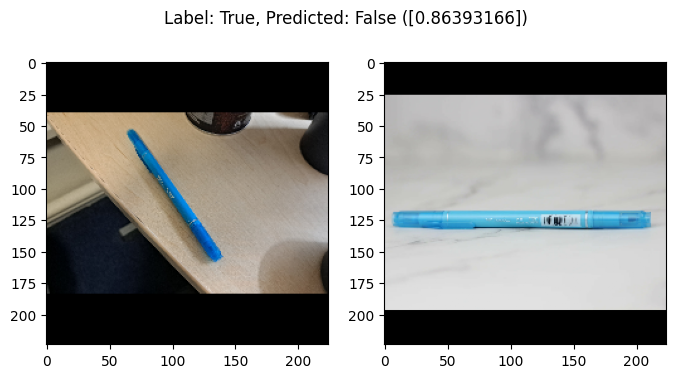

1/1 [==============================] - 0s 16ms/step
Image 1: test/positive/alarm_clock_2/71h-2SPFJlL.jpg
Image 2: test/positive/alarm_clock_2/20250209_202251.jpg
Distance: [0.42848867]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 16ms/step
Image 1: test/positive/camera/sony_zve10_kit_1.jpg
Image 2: test/positive/camera/20250204_194507.jpg
Distance: [0.22481214]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 15ms/step
Image 1: test/positive/digital_watch/51L5xGWtlnL._AC_UF1000,1000_QL80_.jpg
Image 2: test/positive/digital_watch/20250204_202410.jpg
Distance: [0.3560389]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 17ms/step
Image 1: test/positive/power_bank/s-l1200.jpg
Image 2: test/positive/power_bank/20250204_204406.jpg
Distance: [0.2738975]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 16ms/step
Image 1: test/positive/cup/20250204_221531.jpg
Image 2: test/positive/cup/MUG-MS-fi

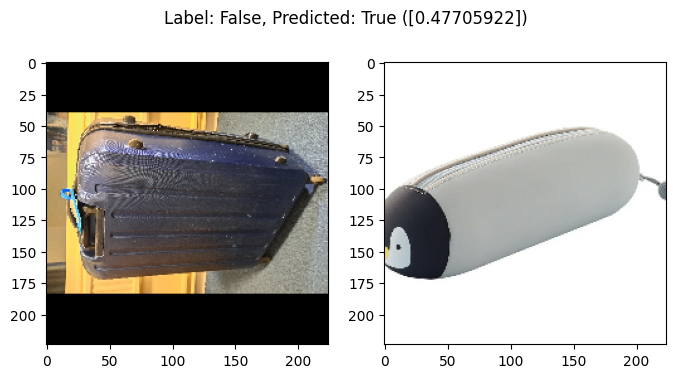

1/1 [==============================] - 0s 16ms/step
Image 1: test/negative_easy/fan/fan-air-conditioner-cooling-rechargeable-freshener-rechargeable-original-imag2zhqymgz8gkc-ezgif.com-webp-to-jpg-converter.jpg
Image 2: test/negative_easy/fan/20250131_001352.jpg
Distance: [0.24178472]
Predicted: [ True]
Label: False


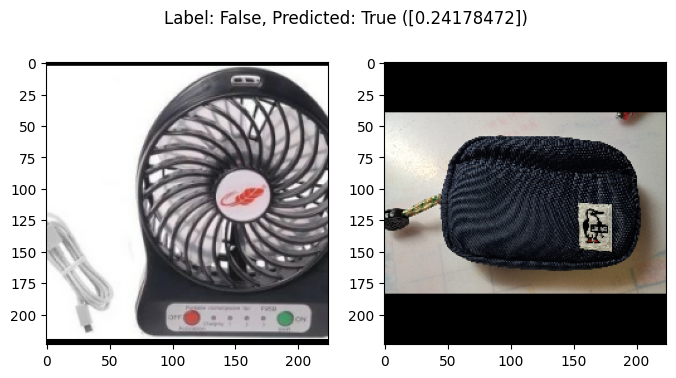

1/1 [==============================] - 0s 15ms/step
Image 1: test/negative_easy/pen/20250204_223826.jpg
Image 2: test/negative_easy/pen/IMG_6322_d32041e0-7f86-426d-8b87-913a35a7bc02.jpg
Distance: [0.34161904]
Predicted: [ True]
Label: False


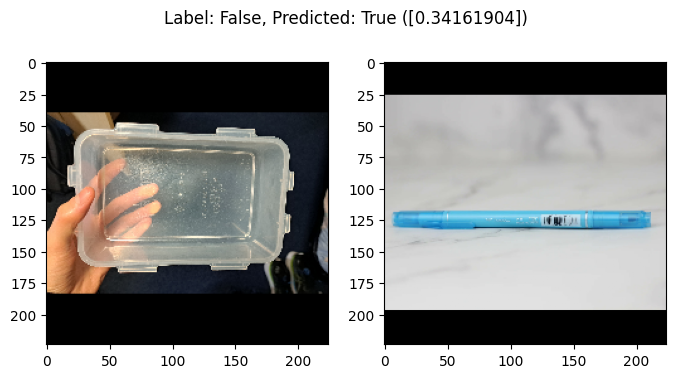

1/1 [==============================] - 0s 15ms/step
Image 1: test/negative_easy/camera/sony_zve10_kit_1.jpg
Image 2: test/negative_easy/camera/20250204_203149.jpg
Distance: [0.16517471]
Predicted: [ True]
Label: False


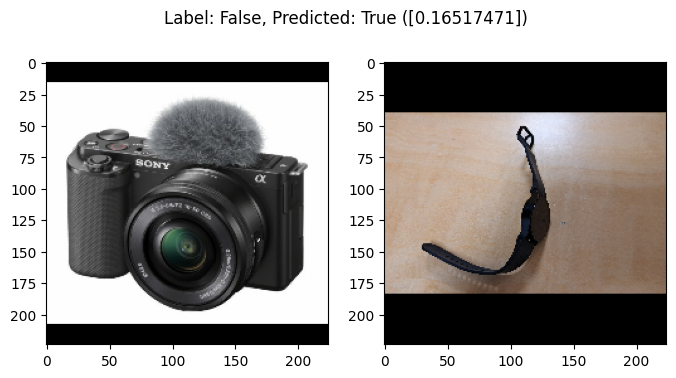

1/1 [==============================] - 0s 22ms/step
Image 1: test/negative_easy/digital_watch/51L5xGWtlnL._AC_UF1000,1000_QL80_.jpg
Image 2: test/negative_easy/digital_watch/20250204_204957.jpg
Distance: [0.31827897]
Predicted: [ True]
Label: False


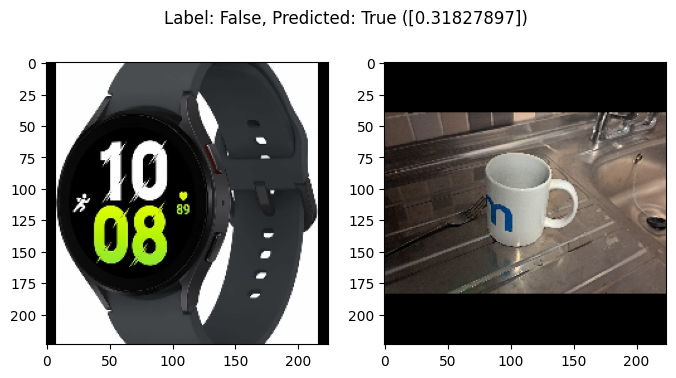

1/1 [==============================] - 0s 16ms/step
Image 1: test/negative_easy/power_bank/20250204_201246.jpg
Image 2: test/negative_easy/power_bank/s-l1200.jpg
Distance: [0.31068134]
Predicted: [ True]
Label: False


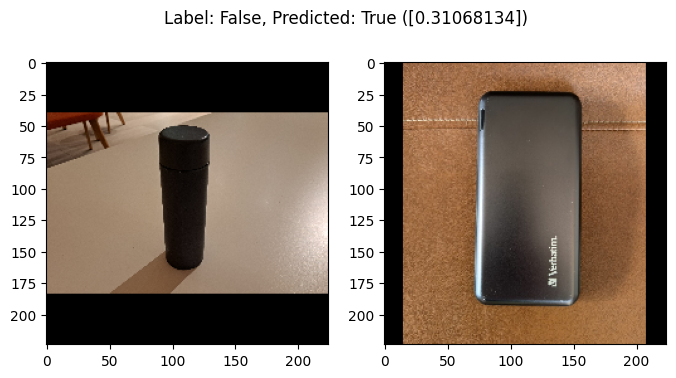

1/1 [==============================] - 0s 17ms/step
Image 1: test/negative_easy/cup/20250204_222610.jpg
Image 2: test/negative_easy/cup/MUG-MS-fine-bone-china-hare-mug-35.jpg
Distance: [0.2833739]
Predicted: [ True]
Label: False


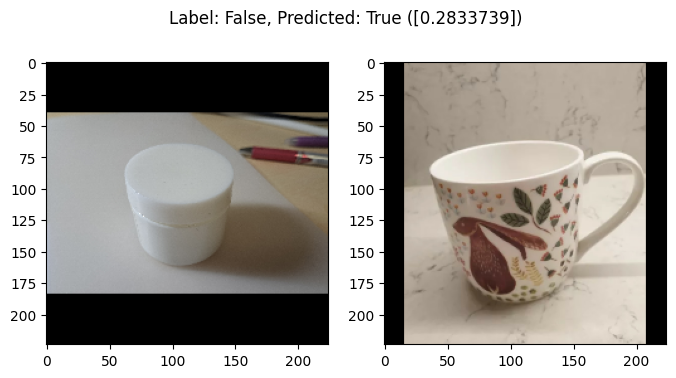

1/1 [==============================] - 0s 17ms/step
Image 1: test/negative_easy/suitcase/xiaomi-lcd-writing-tablet-review.png
Image 2: test/negative_easy/suitcase/683f2eca144e4f8c997727998a7c2e7426db6ea0_6948367055063_G01_ecommerce.jpg
Distance: [0.23221205]
Predicted: [ True]
Label: False


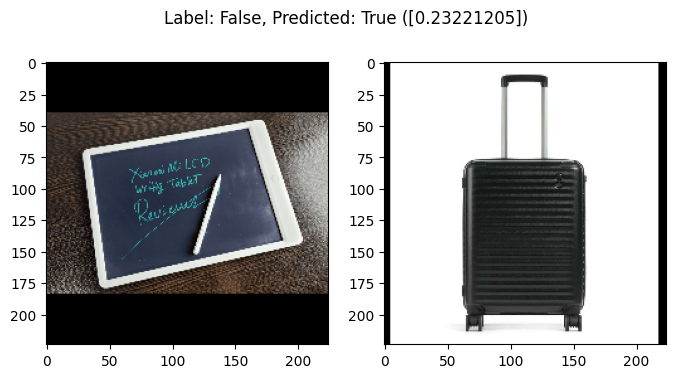

1/1 [==============================] - 0s 19ms/step
Image 1: test/negative_easy/water_pot/20250204_224119.jpg
Image 2: test/negative_easy/water_pot/71Wn0nKphyL._AC_SL1500_.jpg
Distance: [0.24620499]
Predicted: [ True]
Label: False


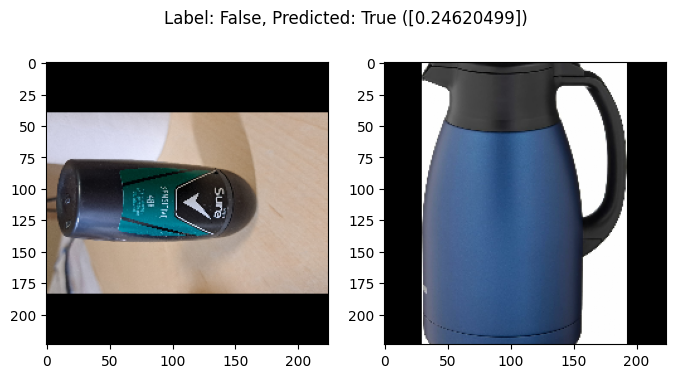

1/1 [==============================] - 0s 15ms/step
Image 1: test/negative_easy/water_bottle/20250204_224100.jpg
Image 2: test/negative_easy/water_bottle/31katMtAaZL.jpg
Distance: [0.3149302]
Predicted: [ True]
Label: False


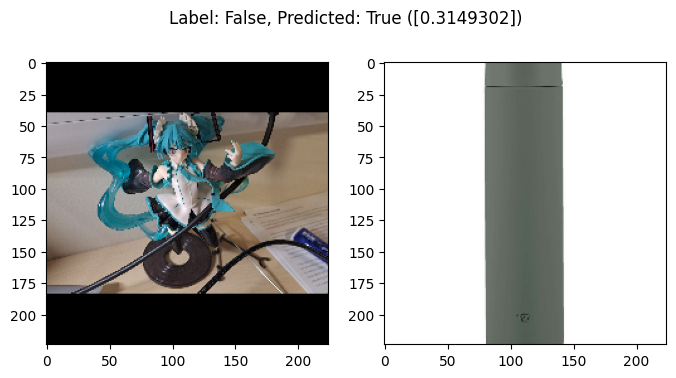

1/1 [==============================] - 0s 16ms/step
Image 1: test/negative_easy/backpack/41SIyEXoYSL._AC_.jpg
Image 2: test/negative_easy/backpack/20250204_222559.jpg
Distance: [0.5003147]
Predicted: [False]
Label: False
1/1 [==============================] - 0s 15ms/step
Image 1: test/negative_easy/alarm_clock/1200x1200.jpg
Image 2: test/negative_easy/alarm_clock/20250204_223802.jpg
Distance: [0.42633623]
Predicted: [ True]
Label: False


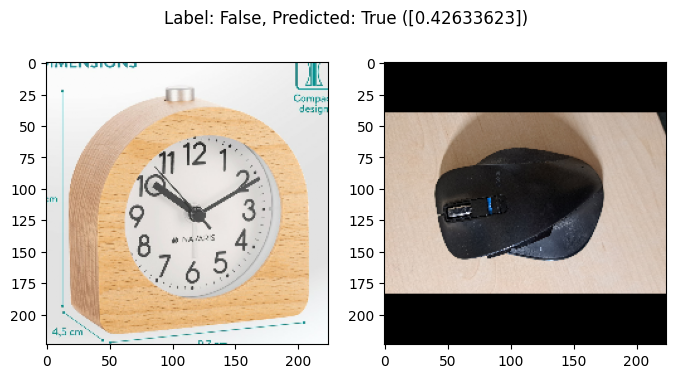

1/1 [==============================] - 0s 19ms/step
Image 1: test/negative_easy/american_football/20250204_223759.jpg
Image 2: test/negative_easy/american_football/American Football.jpg
Distance: [0.2951932]
Predicted: [ True]
Label: False


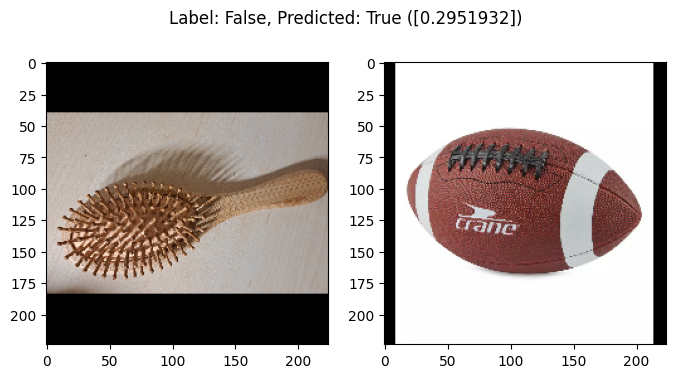

1/1 [==============================] - 0s 19ms/step
Image 1: test/negative_hard/pencil_case/Penguin-Silicone-upright-pencilcase-scaled.jpg
Image 2: test/negative_hard/pencil_case/LL83529-PN_Lihit-Lab-Lying-Pen-Pouch-PuniLabo-Penguin_P3.jpg
Distance: [0.4582001]
Predicted: [ True]
Label: False


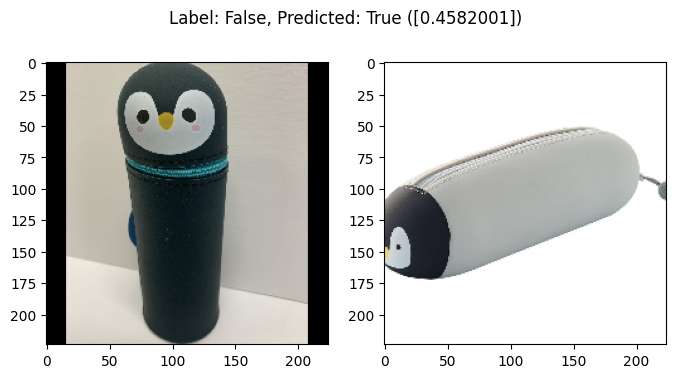

1/1 [==============================] - 0s 17ms/step
Image 1: test/negative_hard/fan/YBnzo5ANvuSdJaJDB9dGcM-320-80.jpg
Image 2: test/negative_hard/fan/fan-air-conditioner-cooling-rechargeable-freshener-rechargeable-original-imag2zhqymgz8gkc-ezgif.com-webp-to-jpg-converter.jpg
Distance: [0.38030177]
Predicted: [ True]
Label: False


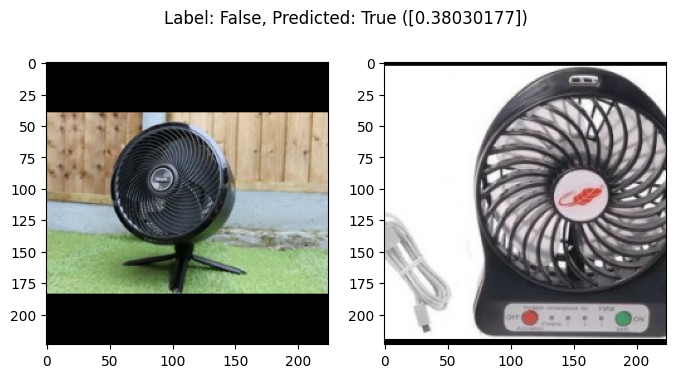

1/1 [==============================] - 0s 15ms/step
Image 1: test/negative_hard/pen/20250131_001152.jpg
Image 2: test/negative_hard/pen/IMG_6322_d32041e0-7f86-426d-8b87-913a35a7bc02.jpg
Distance: [0.19748843]
Predicted: [ True]
Label: False


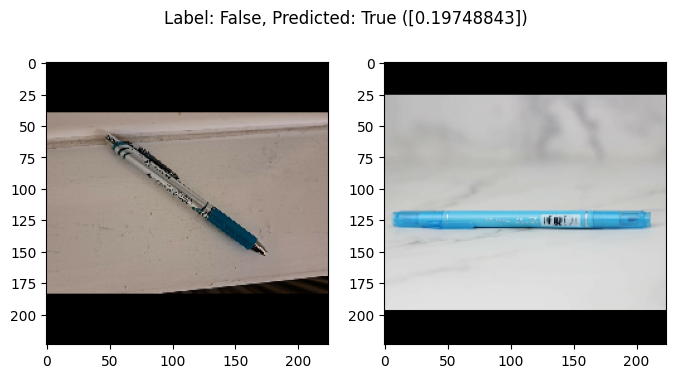

1/1 [==============================] - 0s 25ms/step
Image 1: test/negative_hard/camera/sony_zve10_kit_1.jpg
Image 2: test/negative_hard/camera/NffZWoH4azLn4U2YHz7Kc9.jpg
Distance: [0.20893022]
Predicted: [ True]
Label: False


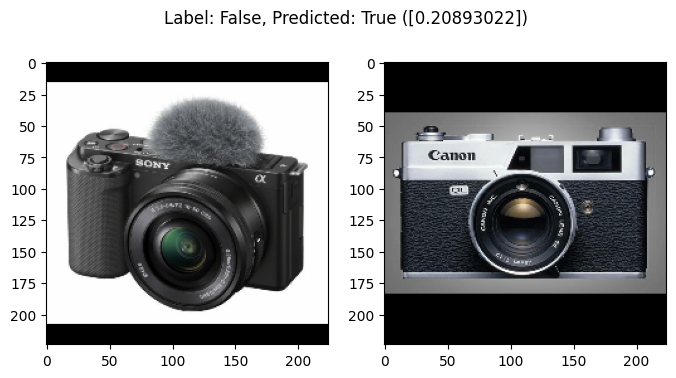

1/1 [==============================] - 0s 16ms/step
Image 1: test/negative_hard/digital_watch/51L5xGWtlnL._AC_UF1000,1000_QL80_.jpg
Image 2: test/negative_hard/digital_watch/images.jpg
Distance: [0.50408566]
Predicted: [False]
Label: False
1/1 [==============================] - 0s 17ms/step
Image 1: test/negative_hard/power_bank/20250204_203223.jpg
Image 2: test/negative_hard/power_bank/s-l1200.jpg
Distance: [0.32558292]
Predicted: [ True]
Label: False


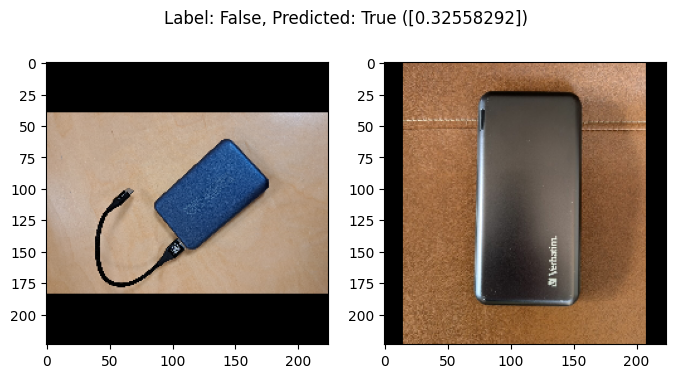

1/1 [==============================] - 0s 20ms/step
Image 1: test/negative_hard/cup/s-l1200.jpg
Image 2: test/negative_hard/cup/MUG-MS-fine-bone-china-hare-mug-35.jpg
Distance: [0.25854355]
Predicted: [ True]
Label: False


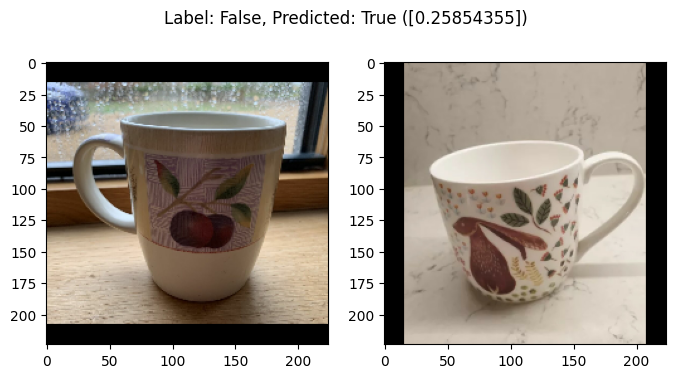

1/1 [==============================] - 0s 17ms/step
Image 1: test/negative_hard/suitcase/683f2eca144e4f8c997727998a7c2e7426db6ea0_6948367055063_G01_ecommerce.jpg
Image 2: test/negative_hard/suitcase/20250204_223619.jpg
Distance: [0.36552987]
Predicted: [ True]
Label: False


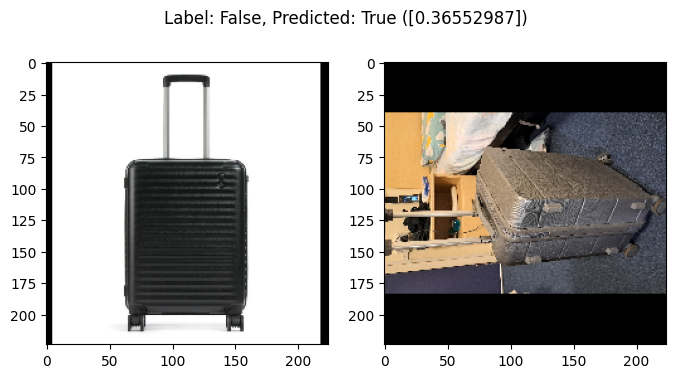

1/1 [==============================] - 0s 14ms/step
Image 1: test/negative_hard/water_pot/20250204_224619.jpg
Image 2: test/negative_hard/water_pot/71Wn0nKphyL._AC_SL1500_.jpg
Distance: [0.28823304]
Predicted: [ True]
Label: False


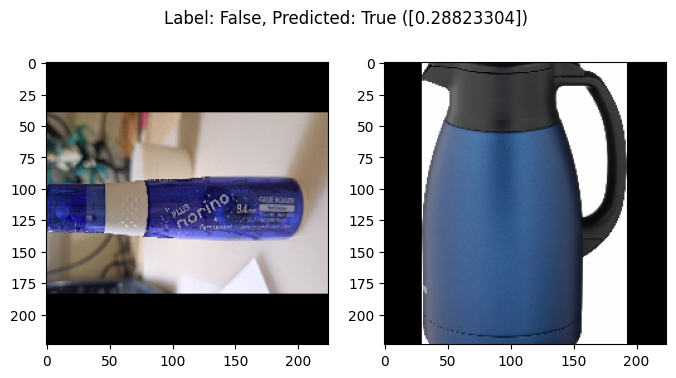

1/1 [==============================] - 0s 17ms/step
Image 1: test/negative_hard/water_bottle/images.jpeg
Image 2: test/negative_hard/water_bottle/31katMtAaZL.jpg
Distance: [0.39474916]
Predicted: [ True]
Label: False


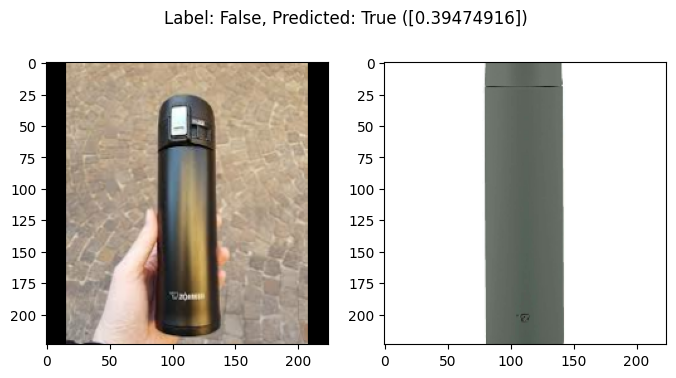

1/1 [==============================] - 0s 16ms/step
Image 1: test/negative_hard/backpack/41SIyEXoYSL._AC_.jpg
Image 2: test/negative_hard/backpack/IMG-20250203-WA0001.jpg
Distance: [0.48148644]
Predicted: [ True]
Label: False


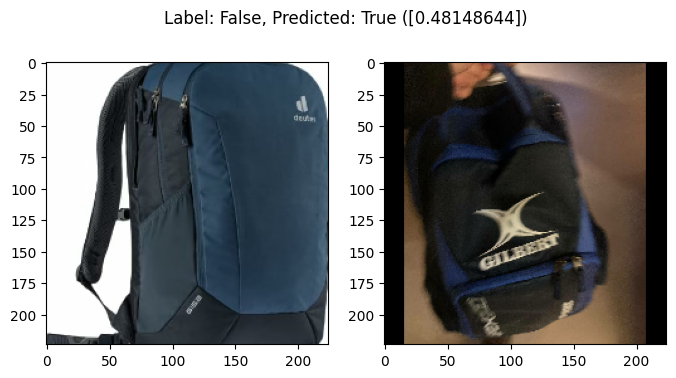

1/1 [==============================] - 0s 18ms/step
Image 1: test/negative_hard/alarm_clock/71D4RsZi2oL.jpg
Image 2: test/negative_hard/alarm_clock/1200x1200.jpg
Distance: [0.24733506]
Predicted: [ True]
Label: False


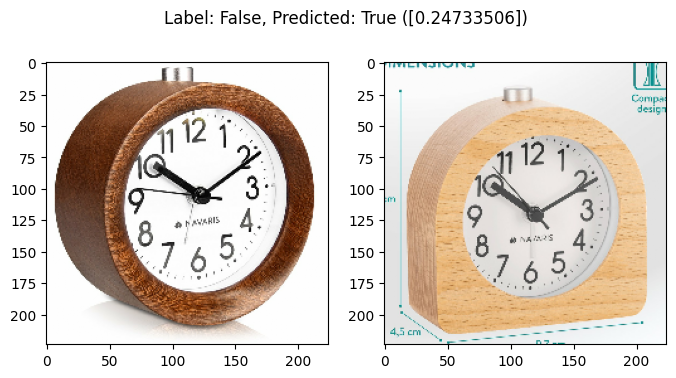

1/1 [==============================] - 0s 15ms/step
Image 1: test/negative_hard/american_football/large_98adad5a-c4f3-431f-afc3-84256a222980.jpg
Image 2: test/negative_hard/american_football/American Football.jpg
Distance: [0.16289985]
Predicted: [ True]
Label: False


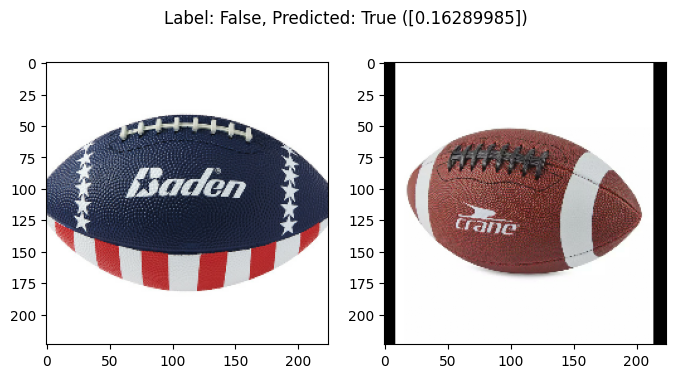

40
15
Accuracy: 0.375
False positive: 24
False negative: 1
Positive accuracy: 0.9285714285714286
Negative easy accuracy: 0.07692307692307693
Negative hard accuracy: 0.07692307692307693


In [21]:
custom_test_data = read_data_test()

THRESHOLD = 0.5

total = 0
correct = 0
false_positive = 0
false_negative = 0

total_positive = 0
positive_correct = 0
total_negative_easy = 0
negative_easy_correct = 0
total_negative_hard = 0
negative_hard_correct = 0

print(custom_test_data)
for ia, ib, label in custom_test_data:
    pa = preprocess(ia)
    pb = preprocess(ib)

    # Add batch dimension
    imgA = tf.expand_dims(pa, axis=0)  # (1, 224, 224, 3)
    imgB = tf.expand_dims(pb, axis=0)  # (1, 224, 224, 3)

    prediction = test_model.predict([imgA, imgB])  
    print(f"Image 1: {ia}")
    print(f"Image 2: {ib}")
    print(f"Distance: {prediction[0]}")
    print(f"Predicted: {prediction[0] <= THRESHOLD}")
    print(f"Label: {bool(label)}")

    truth = bool(label)
    predicted_label = prediction[0] <= THRESHOLD
    if (truth == predicted_label):
        correct += 1
    else:
        if not truth and predicted_label:
            show_preprocessed_image_test(pa, pb, "Label: False, Predicted: True (" + str(prediction[0]) + ")")
            false_positive += 1
        elif truth and not predicted_label:
            show_preprocessed_image_test(pa, pb, "Label: True, Predicted: False (" + str(prediction[0]) + ")")
            false_negative += 1 

    # determine if the sample is positive, negative easy or negative hard
    if ia.split("/")[1] == "positive":
        total_positive += 1
        if truth == predicted_label:
            positive_correct += 1
    if ia.split("/")[1] == "negative_easy":
        total_negative_easy += 1
        if truth == predicted_label:
            negative_easy_correct += 1
    if ia.split("/")[1] == "negative_hard":
        total_negative_hard += 1
        if truth == predicted_label:
            negative_hard_correct += 1

    # increment total count
    total += 1

print(total)
print(correct)
print("====================")
print(f"Accuracy: {correct/total}")
print(f"False positive: {false_positive}")
print(f"False negative: {false_negative}")
print("====================")
print(f"Positive accuracy: {positive_correct/total_positive}")
print(f"Negative easy accuracy: {negative_easy_correct/total_negative_easy}")
print(f"Negative hard accuracy: {negative_hard_correct/total_negative_hard}")